In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# read in raw data
df_wFORM = pd.read_parquet('./datasets/Results from Eneli March 2025/inference_metrics_full_train_with_form.pq')
df_noFORM = pd.read_parquet('./datasets/Results from Eneli March 2025/inference_metrics_full_train_without_form.pq')

# convert timestamps to datetime format
df_wFORM['Datetime'] = pd.to_datetime(df_wFORM['time'])
df_noFORM['Datetime'] = pd.to_datetime(df_noFORM['time'])


# check to verify that the measured (i.e. "true") wind speeds don't change after training
max(df_wFORM['wspeed_true']-df_noFORM['wspeed_true'])

0.0

In [3]:
# extract data based on station ID

# Data trained w/ FORM
FOA_M14_wFORM = df_wFORM[df_wFORM['site_id'] == 111111]
FOA_M31_wFORM = df_wFORM[df_wFORM['site_id'] == 111112]
FOA_M7_wFORM  = df_wFORM[df_wFORM['site_id'] == 111113]
FOA_M54_wFORM = df_wFORM[df_wFORM['site_id'] == 111114]
Ammonit_wFORM = df_wFORM[df_wFORM['site_id'] == 210078]

# Data trained w/o FORM
FOA_M14_noFORM = df_noFORM[df_noFORM['site_id'] == 111111]
FOA_M31_noFORM = df_noFORM[df_noFORM['site_id'] == 111112]
FOA_M7_noFORM  = df_noFORM[df_noFORM['site_id'] == 111113]
FOA_M54_noFORM = df_noFORM[df_noFORM['site_id'] == 111114]
Ammonit_noFORM = df_noFORM[df_noFORM['site_id'] == 210078]


In [4]:
# Find common timestamps b/w FOA_M7 and Ammonit
# Otherwise, comparing wind speeds at mismatched times is meaningless
common_timestamps_wFORM = set(FOA_M7_wFORM['Datetime']).intersection(set(Ammonit_wFORM['Datetime']))
common_timestamps_noFORM = set(FOA_M7_noFORM['Datetime']).intersection(set(Ammonit_noFORM['Datetime']))

# verify that timestamps are the same
if common_timestamps_noFORM == common_timestamps_wFORM:
    pass
else:
    print("Mismatch")
  

# make new DataFrame with just the overlapping timestamps
FOA_M7_wFORM_common  = FOA_M7_wFORM[FOA_M7_wFORM['Datetime'].isin(common_timestamps_wFORM)]
FOA_M7_noFORM_common = FOA_M7_noFORM[FOA_M7_noFORM['Datetime'].isin(common_timestamps_noFORM)]
Ammonit_wFORM_common = Ammonit_wFORM[Ammonit_wFORM['Datetime'].isin(common_timestamps_wFORM)]
Ammonit_noFORM_common = Ammonit_noFORM[Ammonit_noFORM['Datetime'].isin(common_timestamps_noFORM)]

# sort by timestamp
FOA_M7_wFORM_common  = FOA_M7_wFORM_common.sort_values(by='Datetime')
FOA_M7_noFORM_common = FOA_M7_noFORM_common.sort_values(by='Datetime')
Ammonit_wFORM_common = Ammonit_wFORM_common.sort_values(by='Datetime')
Ammonit_noFORM_common = Ammonit_noFORM_common.sort_values(by='Datetime')

# reset index to start from 0
FOA_M7_wFORM_common.reset_index(drop=True, inplace=True)
FOA_M7_noFORM_common.reset_index(drop=True, inplace=True)
Ammonit_wFORM_common.reset_index(drop=True, inplace=True)
Ammonit_noFORM_common.reset_index(drop=True, inplace=True)



In [5]:
# Verifications before analysis can proceed

# verify that Ammonit wspeed_true (i.e., measured wind speed) is same for w/ and w/o training
Ammonit_diff = Ammonit_wFORM['wspeed_true'] == Ammonit_noFORM['wspeed_true']
for i, is_equal in enumerate(Ammonit_diff):
    if not is_equal:
        print("Mismatch")



# Although Ammonit and FOA_M7 are at the same location, are the GR predictions close to each other?

predicted_diff_wFORM = FOA_M7_wFORM_common['wspeed_pred'] - Ammonit_wFORM_common['wspeed_pred']
print(max(predicted_diff_wFORM))

predicted_diff_noFORM = FOA_M7_noFORM_common['wspeed_pred'] - Ammonit_noFORM_common['wspeed_pred']
print(max(predicted_diff_noFORM))

0.0
0.0


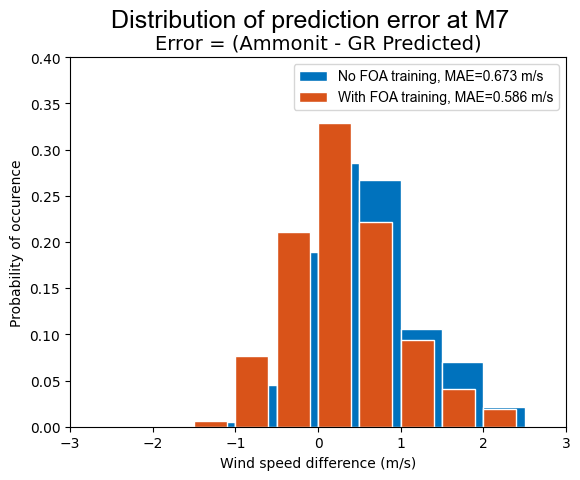

In [6]:
# Make histogram of M7 error distribution

# Define error as (Ammonit wind speed) - (Predicted wind speed)
FOA_M7_error_wFORM = Ammonit_wFORM_common['wspeed_true'] - FOA_M7_wFORM_common['wspeed_pred']
FOA_M7_error_noFORM = Ammonit_noFORM_common['wspeed_true'] - FOA_M7_noFORM_common['wspeed_pred']

# Compute MAE
FOA_M7_wFORM_MAE = abs(Ammonit_wFORM_common['wspeed_true'] - FOA_M7_wFORM_common['wspeed_pred']).mean()
FOA_M7_noFORM_MAE = abs(Ammonit_noFORM_common['wspeed_true'] - FOA_M7_noFORM_common['wspeed_pred']).mean()

# set wind speed range bins
bin_edges = np.arange(-3, 3, 0.5)

# Compute the weights for each dataset to normalize histogram
weights_wFORM = np.ones_like(FOA_M7_error_wFORM) / len(FOA_M7_error_wFORM)
weights_noFORM = np.ones_like(FOA_M7_error_noFORM) / len(FOA_M7_error_noFORM)

# Make plots
plt.hist(FOA_M7_error_noFORM, bins=bin_edges, color=(0, 0.4470, 0.7410), edgecolor='white', 
         align='mid', weights=weights_noFORM)
plt.hist(FOA_M7_error_wFORM, bins=bin_edges, color=(0.8500, 0.3250, 0.0980), edgecolor='white',  
         align='mid', weights=weights_wFORM, width=0.4)


# Add a title and labels
plt.rcParams["font.family"] = "Arial"
plt.suptitle('Distribution of prediction error at M7', fontsize=18)
plt.title('Error = (Ammonit - GR Predicted)', fontsize=14)
plt.xlabel('Wind speed difference (m/s)')
plt.ylabel('Probability of occurence')
plt.ylim(0, 0.4)
plt.xlim(-3, 3)
plt.legend([f"No FOA training, MAE={FOA_M7_noFORM_MAE:.3f} m/s",
            f"With FOA training, MAE={FOA_M7_wFORM_MAE:.3f} m/s"])

# Show the plot
plt.show()

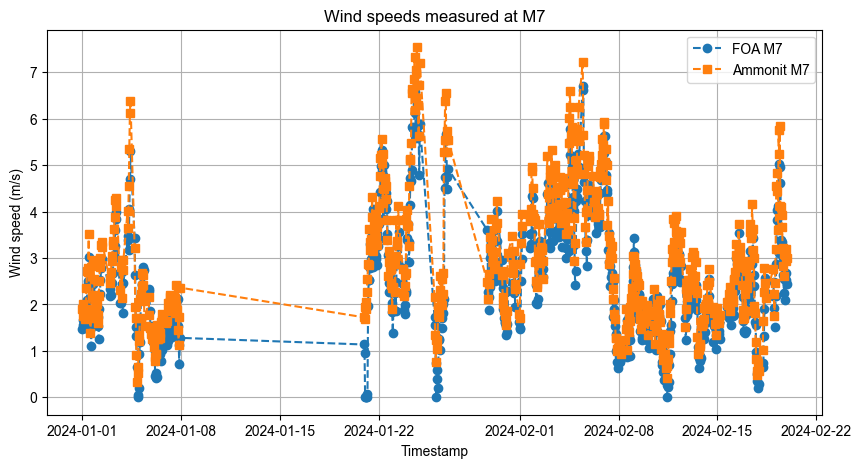

In [7]:
# Plot time-series wind values
# Objective is to make sure FOA_M7 and Ammonit measured wind speeds are aligned in time

measured_MAE_M7 = abs(Ammonit_wFORM_common['wspeed_true'] - FOA_M7_wFORM_common['wspeed_true'])

plt.rc('font', family='Arial')
plt.figure(figsize=(10, 5))
plt.plot(FOA_M7_wFORM_common['Datetime'], FOA_M7_wFORM_common['wspeed_true'], marker='o', linestyle='--', label='FOA M7')
plt.plot(Ammonit_wFORM_common['Datetime'], Ammonit_wFORM_common['wspeed_true'], marker='s', linestyle='--', label='Ammonit M7')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speeds measured at M7')
plt.legend()
plt.grid(True)
plt.show()

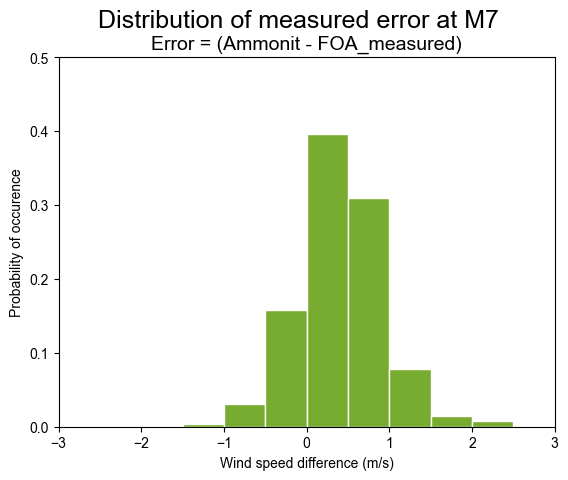

In [8]:
# Make histogram of FOA_M7 and Ammonit measured wind speeds

# Define error as (Ammonit wind speed) - (FOA_M7 wind speed)
measured_M7_error = Ammonit_wFORM_common['wspeed_true'] - FOA_M7_wFORM_common['wspeed_true']

# set wind speed range bins
bin_edges = np.arange(-3, 3, 0.5)

# Compute the weights for each dataset to normalize histogram
weights_measured_M7_error = np.ones_like(measured_M7_error) / len(measured_M7_error)

# Make plot
plt.hist(measured_M7_error, bins=bin_edges, color=(0.4660, 0.6740, 0.1880), edgecolor='white', 
         align='mid', weights=weights_noFORM)

# Add a title and labels
plt.rcParams["font.family"] = "Arial"
plt.suptitle('Distribution of measured error at M7', fontsize=18)
plt.title('Error = (Ammonit - FOA_measured)', fontsize=14)
plt.xlabel('Wind speed difference (m/s)')
plt.ylabel('Probability of occurence')
plt.ylim(0, 0.5)
plt.xlim(-3, 3)

# Show the plot
plt.show()